# Zipline Coding Exercises

In this notebook you will create your own pipeline and create custom factors and filters for it. 

### Install Packages

In [2]:
import sys
!{sys.executable} -m pip install -r requirements.txt

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# Load Data

In [7]:
import os

from zipline.data import bundles
from zipline.data.bundles.csvdir import csvdir_equities


# Specify the bundle name
bundle_name = 'm4-quiz-eod-quotemedia'

# Create an ingest function 
ingest_func = csvdir_equities(['daily'], bundle_name)

# Register the data bundle and its ingest function
bundles.register(bundle_name, ingest_func);

# Set environment variable 'ZIPLINE_ROOT' to the path where the most recent data is located
os.environ['ZIPLINE_ROOT'] = os.path.join(os.getcwd(), '..', '..', 'data', 'module_4_quizzes_eod')

# Load the data bundle
bundle_data = bundles.load(bundle_name)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Overwriting bundle with name 'm4-quiz-eod-quotemedia'
  


# TODO: Build an Empty Pipeline with a Screen

In the code below create an empty with a screen that filters the pipeline output for stocks with a 60-day average dollar volume greater than \$50,000.

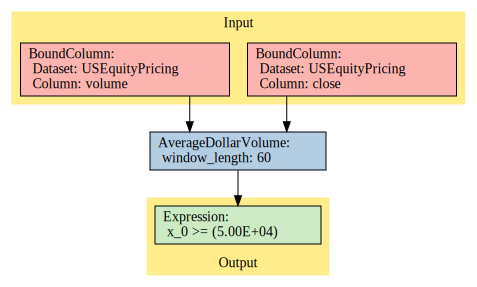

In [29]:
# import resources
from zipline.pipeline import Pipeline
from zipline.pipeline.factors import AverageDollarVolume

# Create a screen for our Pipeline
universe = AverageDollarVolume(window_length=60) >= 50000

# Create an empty Pipeline with the given screen
pipeline = Pipeline(screen=universe)
pipeline.show_graph()

# TODO: Create a Pipeline Engine

In the code below, create a data loader that loads our data bundle using Zipline's `USEquityPricingLoader`. Then create a function to be passed to the `get_loader` parameter in the pipeline engine. Using the NYSE trading calendar create a pipeline engine using Zipline's `SimplePipelineEngine`

In [30]:
# import resources
from zipline.pipeline.loaders import USEquityPricingLoader
from zipline.pipeline.data import USEquityPricing
from zipline.utils.calendars import get_calendar
from zipline.pipeline.engine import SimplePipelineEngine


# Set the dataloader
pricing_loader = USEquityPricingLoader(bundle_data.equity_daily_bar_reader, bundle_data.adjustment_reader)

# Define the function for the get_loader parameter
def choose_loader(column):
    if column not in USEquityPricing.columns:
        raise Exception('Column not in USEquityPricing')
    return pricing_loader
# Set the trading calendar
trading_calendar = get_calendar('NYSE')

# Create a Pipeline engine
engine = SimplePipelineEngine(get_loader=choose_loader, calendar=trading_calendar.all_sessions, asset_finder=bundle_data.asset_finder)


# TODO: Create Factors and Filters For The Pipeline

### Factors

In the code below, create two factors:

1. **Custom Factor**: Create a custom factor, `percent_difference`,  by combining a 30-day average closing price factor and a 60-average closing price factor. The `percent_difference` factor will calculate the difference between the 30-day and 60-average closing price factors, and will then normalize this difference by the 60-average closing price factor.


2. **Daily Returns Factor**: Create a factor that returns the daily percent change in closing price. To do this, use Zipline's built-in [DailyReturns](https://www.zipline.io/appendix.html#zipline.pipeline.factors.DailyReturns) factor.

Both factors should use the closing prices in the `USEquityPricing`  dataset as inputs. 




### Filters

In the code below, you will create a **Custom Filter**, `tradable_asset`, that returns `True` for the top 20 securities of average dollar volume in a 30 day-window that have a latest closing price above \$30. To do this, you will create two filters first and them combine them. For the first filter, you can use Zipline's built-in factor `AverageDollarVolume()` and its method `.top()` to select the top 20 assets of average dollar volume in a 30 day-window. To get the latest close price of the `USEquityPricing` dataset you can use `USEquityPricing.close.latest`. Finally you can combine these two filters by using the logical operator `&`. 

In [39]:
# import resources
from zipline.pipeline.factors import SimpleMovingAverage
from zipline.pipeline.factors import DailyReturns

# Create the 30-day average closing price factor
ma_close_30 = SimpleMovingAverage(inputs=[USEquityPricing.close], window_length=30)

# Create the 60-day average closing price factor
ma_close_60 = SimpleMovingAverage(inputs=[USEquityPricing.close], window_length=60)

# Create the custom factor
custom_factor = (ma_close_30 - ma_close_60) / ma_close_60

# Create the daily returns factor
daily_returns = DailyReturns(inputs=[USEquityPricing.close])

# Create a filter for the top 20 securities of average dollar volume in a 30 day-window
top_20_volume = AverageDollarVolume(window_length=30).top(20)

# Create a filter for the latest closing price above $30
above_30 = USEquityPricing.close.latest > 30


# Create a custum filter
tradable_asset = top_20_volume & above_30

# TODO: Add Factors and Filters To The Pipeline

In the code below, add the factors and filters you created above to the pipeline

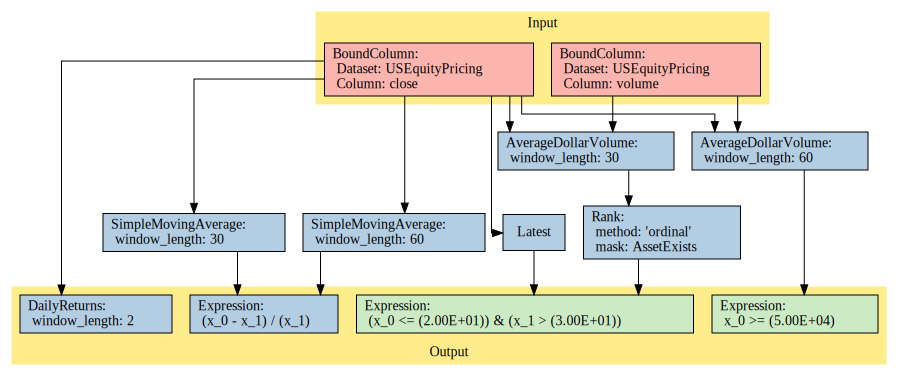

In [45]:
# Add the custom factor to the pipeline
#pipeline.add(custom_factor, 'Percent Difference')

# Add the daily returns factor to the pipeline
#pipeline.add(daily_returns, 'Daily Return')

# Add the custom filter to the pipeline
#pipeline.add(tradable_asset, 'Tradable')
pipeline.show_graph()


# TODO: Run The Pipeline

In the code below, run the pipeline for the dates given

In [48]:
# Set starting and end dates
import pandas as pd
start_date = pd.Timestamp('2014-01-06', tz='utc')
end_date = pd.Timestamp('2016-01-05', tz='utc')

# Run our pipeline for the given start and end dates
output = engine.run_pipeline(pipeline, start_date, end_date)

# Display the pipeline output
output.head()

Daily Return  Percent Difference  \
2014-01-06 00:00:00+00:00 Equity(0 [A])         0.006951            0.025939   
                          Equity(1 [AAL])       0.046523            0.055887   
                          Equity(2 [AAP])       0.028611            0.051009   
                          Equity(3 [AAPL])     -0.021972            0.035906   
                          Equity(4 [ABBV])      0.006147            0.033018   

                                            Tradable  
2014-01-06 00:00:00+00:00 Equity(0 [A])        False  
                          Equity(1 [AAL])      False  
                          Equity(2 [AAP])      False  
                          Equity(3 [AAPL])      True  
                          Equity(4 [ABBV])     False

## Solution

[Solution notebook](zipline_coding_exercises_solution.ipynb)